In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from fuzzywuzzy import fuzz

import networkx
from networkx.algorithms.components.connected import connected_components


from os.path import join
import json

In [2]:
!cat data/union.json | wc -l

   25067


In [3]:
!ls data

countries_vocab.json       quotes-2013-processed.json
occupations_vocab.json     quotes-2014-merged.json
quotes-2008-merged.json    quotes-2014-processed.json
quotes-2008-processed.json quotes-2015-merged.json
quotes-2009-merged.json    quotes-2015-processed.json
quotes-2009-processed.json quotes-2016-merged.json
quotes-2010-merged.json    quotes-2016-processed.json
quotes-2010-processed.json quotes-2017-merged.json
quotes-2011-merged.json    quotes-2017-processed.json
quotes-2011-processed.json quotes-2019-processed.json
quotes-2012-merged.json    quotes-2020-processed.json
quotes-2012-processed.json union.json
quotes-2013-merged.json


In [4]:
DATA_PATH = 'data'

In [5]:
with open(join(DATA_PATH, 'countries_vocab.json'), 'r') as f:
    countries_dict = json.loads(f.readline())
    
with open(join(DATA_PATH, 'occupations_vocab.json'), 'r') as f:
    occupations_dict = json.loads(f.readline())

In [6]:
len(set(v.lower() for v in occupations_dict.values()))

1249

In [7]:
len(set(v for v in occupations_dict.values()))

1252

In [8]:
df = pd.read_json(join(DATA_PATH, 'union.json'), lines=True)
df.head()

,q,d,id,s,o,gender,birth,occupation_ids,citizenship_id
0,will be playing a lot of the tracks from micro...,2008-12-02 17:59:33,[Q2359518],lockett pundt,1,[male],[+1982-10-07T00:00:00Z],[[Q855091]],[Q30]
1,the corporation looks a bit concerned there te...,2008-10-16 01:39:41,[Q52607733],tessa martin,2,[female],[None],[[Q2500638]],[None]
2,the broker who supposed a large shareholder ha...,2008-12-01 10:39:05,"[Q16148910, Q19938265, Q313918, Q4771995, Q477...",anthony anderson,1,"[male, male, male, male, male]","[+1901-00-00T00:00:00Z, +1981-11-12T00:00:00Z,...","[[Q3282637], [Q3665646], [Q245068, Q10800557, ...","[None, Q30, Q30, Q30, Q145]"
3,whining and bitching and am a sore loser,2008-11-05 07:41:00,[Q76],barack obama,2,[male],[+1961-08-04T00:00:00Z],"[[Q82955, Q40348, Q15958642, Q28532974, Q37243...",[Q30]
4,everybody is a bit concerned with the economy ...,2008-10-17 01:25:29,[Q17180637],jake hansen,3,[male],[+1989-08-21T00:00:00Z],[[Q11774891]],[Q30]


In [9]:
def change_occupancy_ids_to_names(values: list, dicitonary: dict) -> list:
    """
    :param: values - list of lists of ids
    :param: dicitonary - dictionary for id - name matching
    
    return list strings with union of all possible occupancies for a person
    """
    ans = []
    for quote_array in values:
        person_values = []
        for wikipage_array in quote_array:
            values_ = []
            if wikipage_array is None or len(wikipage_array) == 0:
                values_.append("None")
            else:
                for value_id in wikipage_array:
                    values_.append(dicitonary[value_id])
            person_values.append(values_)
        ans.append(person_values)
        
    return ans

In [10]:
df['occupations'] = change_occupancy_ids_to_names(df.occupation_ids, occupations_dict)
df['occupations']

0                                            [[guitarist]]
1                                              [[creator]]
2        [[film producer], [basketball player], [comedi...
3        [[politician, lawyer, political writer, commun...
4                                    [[ice hockey player]]
                               ...                        
25062    [[trumpeter, university teacher, composer, ban...
25063                  [[film producer, lawyer, lobbyist]]
25064    [[politician, surgeon, air force officer, gyna...
25065                 [[Australian rules football player]]
25066          [[sociologist], [ship-owner, ship captain]]
Name: occupations, Length: 25067, dtype: object

In [11]:
df['citizenship'] = df['citizenship_id'].apply(lambda x: list(None if not c else countries_dict[c] for c in x))
df['citizenship']

0                               [United States of America]
1                                                   [None]
2        [None, United States of America, United States...
3                               [United States of America]
4                               [United States of America]
                               ...                        
25062                           [United States of America]
25063                           [United States of America]
25064                           [United States of America]
25065                                          [Australia]
25066                     [United States of America, None]
Name: citizenship, Length: 25067, dtype: object

In [12]:
def select_first_from_list(values, depth=1) -> list:
    temp_values = list('None' if v == [] else v[0] for v in values)
            
    if depth == 1:
        return temp_values
    else:
        return select_first_from_list(temp_values, depth=depth-1)

In [13]:
df['citizenship_first'] = select_first_from_list(values=df['citizenship'])
df['citizenship_first']

0        United States of America
1                            None
2                            None
3        United States of America
4        United States of America
                   ...           
25062    United States of America
25063    United States of America
25064    United States of America
25065                   Australia
25066    United States of America
Name: citizenship_first, Length: 25067, dtype: object

In [14]:
df['occupation_first'] = select_first_from_list(values=df['occupations'], depth=2)
df['occupation_first']

0                               guitarist
1                                 creator
2                           film producer
3                              politician
4                       ice hockey player
                       ...               
25062                           trumpeter
25063                       film producer
25064                          politician
25065    Australian rules football player
25066                         sociologist
Name: occupation_first, Length: 25067, dtype: object

In [15]:
df['gender_first'] = select_first_from_list(values=df['gender'])
df['birth_first'] = select_first_from_list(values=df['birth'])

In [16]:
df['year'] = df['d'].apply(lambda x: x[:4])
df['month'] = df['d'].apply(lambda x: x[5:7])
df.head()

,q,d,id,s,o,gender,birth,occupation_ids,citizenship_id,occupations,citizenship,citizenship_first,occupation_first,gender_first,birth_first,year,month
0,will be playing a lot of the tracks from micro...,2008-12-02 17:59:33,[Q2359518],lockett pundt,1,[male],[+1982-10-07T00:00:00Z],[[Q855091]],[Q30],[[guitarist]],[United States of America],United States of America,guitarist,male,+1982-10-07T00:00:00Z,2008,12
1,the corporation looks a bit concerned there te...,2008-10-16 01:39:41,[Q52607733],tessa martin,2,[female],[None],[[Q2500638]],[None],[[creator]],[None],None,creator,female,None,2008,10
2,the broker who supposed a large shareholder ha...,2008-12-01 10:39:05,"[Q16148910, Q19938265, Q313918, Q4771995, Q477...",anthony anderson,1,"[male, male, male, male, male]","[+1901-00-00T00:00:00Z, +1981-11-12T00:00:00Z,...","[[Q3282637], [Q3665646], [Q245068, Q10800557, ...","[None, Q30, Q30, Q30, Q145]","[[film producer], [basketball player], [comedi...","[None, United States of America, United States...",None,film producer,male,+1901-00-00T00:00:00Z,2008,12
3,whining and bitching and am a sore loser,2008-11-05 07:41:00,[Q76],barack obama,2,[male],[+1961-08-04T00:00:00Z],"[[Q82955, Q40348, Q15958642, Q28532974, Q37243...",[Q30],"[[politician, lawyer, political writer, commun...",[United States of America],United States of America,politician,male,+1961-08-04T00:00:00Z,2008,11
4,everybody is a bit concerned with the economy ...,2008-10-17 01:25:29,[Q17180637],jake hansen,3,[male],[+1989-08-21T00:00:00Z],[[Q11774891]],[Q30],[[ice hockey player]],[United States of America],United States of America,ice hockey player,male,+1989-08-21T00:00:00Z,2008,10


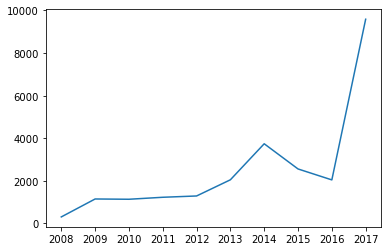

In [17]:
plt.plot(df.groupby('year')['q'].count())
plt.show()

In [18]:
df.groupby(['month', 'year'])['q'].count()

month  year
01     2009      59
       2010     105
       2011     121
       2012      86
       2013      90
               ... 
12     2013     340
       2014     224
       2015     336
       2016     332
       2017    2253
Name: q, Length: 112, dtype: int64

---

#### We can see 2 noticeable peaks, in 2014 and 2017. We want to understand the following things

- who (by occupation) was talking about the ctyptocurrencies/bitcoins/etc throughout the years
- first thing we want to understand is: why peaks are exactly in those years. What happened there that made such a peak 

In [19]:
df.groupby(['year', 'occupation_first'])['q'].count().sort_values(ascending=False)

year  occupation_first           
2017  politician                     740
      None                           553
      association football player    536
      businessperson                 458
      economist                      427
                                    ... 
2012  helicopter pilot                 1
2016  sports journalist                1
2012  hacker                           1
2016  sports official                  1
2013  storyboard artist                1
Name: q, Length: 2299, dtype: int64

In [20]:
df.groupby(['year', 's'])['q'].count().sort_values(ascending=False)

year  s              
2017  Jamie Dimon        140
      Charlie Lee        129
      Tom Lee             86
      Vitalik Buterin     79
2014  Tony Gallippi       77
                        ... 
2015  GEORGE Shelley       1
      Fredenil Castro      1
      Fred Talbot          1
      Fred Hoiberg         1
2008  Adam Campbell        1
Name: q, Length: 12744, dtype: int64

#### Now we need to find same names and occupancies (...)

In [21]:
n = len(occupations_dict)
occupations = list(occupations_dict.values())
dist = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        dist[i, j] = fuzz.partial_ratio(occupations[i], occupations[j]) > 95

In [22]:
G = networkx.convert_matrix.from_numpy_matrix(dist)

cliques = list(networkx.find_cliques(G))
cliques_text = list(list(map(lambda x: occupations[x], c)) for c in cliques)

In [23]:
cliques_text

[['organizational founder'],
 ['paramedic'],
 ['table tennis player', 'tennis player'],
 ['outsider art'],
 ['windsurfer', 'surfer'],
 ['drawer'],
 ['hispanist'],
 ['sports commentator', 'esports commentator'],
 ['polar explorer', 'explorer'],
 ['assistant director', 'assistant'],
 ['assistant director', 'director', 'director', 'rector'],
 ['magician'],
 ['film crew member'],
 ['flight instructor'],
 ['interior designer', 'designer'],
 ['hedge fund manager', 'manager', 'manager', 'manager', 'fund manager'],
 ['hedge fund manager', 'hedge fund'],
 ['ironworker'],
 ['data scientist', 'scientist'],
 ['Internet activist', 'activist'],
 ['high jumper'],
 ['clarinetist'],
 ['police officer', 'police officer'],
 ['competitive diver', 'diver'],
 ['beach volleyball player', 'volleyball player'],
 ['video game critic', 'critic'],
 ['reality television participant'],
 ['track cycling'],
 ['art thief'],
 ['recluse'],
 ['impressionist'],
 ['child actor', 'actor'],
 ['reader'],
 ['cantante de tonada

In [24]:
# https://stackoverflow.com/questions/4842613/merge-lists-that-share-common-elements
def to_graph(l):
    G = networkx.Graph()
    for part in l:
        # each sublist is a bunch of nodes
        G.add_nodes_from(part)
        # it also implies a number of edges:
        G.add_edges_from(to_edges(part))
    return G

def to_edges(l):
    it = iter(l)
    last = next(it)

    for current in it:
        yield last, current
        last = current

In [64]:
G = to_graph(cliques)
simmilar_occupasions = list(connected_components(G))
SIMILAR_OCCUPATIONS_DICT = {i: list(map(lambda x: occupations[x], c)) for i,c in enumerate(simmilar_occupasions)}

In [65]:
def find_occupation_group(occupation):
    for i, group_occupations in SIMILAR_OCCUPATIONS_DICT.items():
        if occupation in group_occupations:
            return i

In [66]:
df['occupation_first_group'] = df['occupation_first'].apply(lambda x: find_occupation_group(x))

In [67]:
len(df['occupation_first'].unique()), len(df['occupation_first_group'].unique())

(652, 422)

---

##### Now we can group by occupation category

In [87]:
df.groupby('occupation_first_group')['q'].count().sort_values(ascending=False).head(7)

occupation_first_group
376.0    1972
9.0      1360
29.0     1351
42.0     1345
220.0    1309
571.0     964
34.0      916
Name: q, dtype: int64

In [89]:
SIMILAR_OCCUPATIONS_DICT[376], SIMILAR_OCCUPATIONS_DICT[34]

(['permanent politician', 'geopolitician', 'politician'],
 ['medical researcher',
  'market researcher',
  'tourism researcher',
  'researcher',
  'archer',
  'peace and conflict researcher',
  'artificial intelligence researcher',
  'archer',
  'design researcher',
  'security researcher'])

---

In [209]:
a = df.groupby(['year'], as_index=False)

In [215]:
for group in a.groups:
    print('----', group, '----')
    print(a.get_group(group).groupby('occupation_first_group').count().nlargest(5, 'q')['q'])

---- 2008 ----
occupation_first_group
376.0    43
42.0     27
29.0     20
220.0    16
9.0      14
Name: q, dtype: int64
---- 2009 ----
occupation_first_group
376.0    139
42.0      98
29.0      91
9.0       55
220.0     52
Name: q, dtype: int64
---- 2010 ----
occupation_first_group
376.0    133
42.0      77
220.0     71
29.0      61
46.0      55
Name: q, dtype: int64
---- 2011 ----
occupation_first_group
29.0     154
376.0    126
42.0      76
220.0     70
46.0      56
Name: q, dtype: int64
---- 2012 ----
occupation_first_group
376.0    135
42.0      84
29.0      81
220.0     73
46.0      58
Name: q, dtype: int64
---- 2013 ----
occupation_first_group
180.0    123
42.0     122
376.0    112
29.0     110
220.0     95
Name: q, dtype: int64
---- 2014 ----
occupation_first_group
376.0    234
9.0      231
571.0    228
42.0     200
29.0     180
Name: q, dtype: int64
---- 2015 ----
occupation_first_group
376.0    164
9.0      155
220.0    145
34.0     136
29.0     120
Name: q, dtype: int64
---- 